In [14]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader.data as web
from arch import arch_model
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.stats import norm, skewnorm, kurtosis, skew, moment

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import warnings

# To ignore all warnings
warnings.filterwarnings("ignore")

In [15]:
def required_formatting(df):
    if df.index.name != "Date":
        df["Date"] = pd.to_datetime(df["Date"])
        df.set_index("Date", inplace = True)
    df["return"] = df["Adj Close"].pct_change().fillna(0)
    df["returns"] = np.log(1+df["return"])*100

nifty50 = pd.read_csv("NSEI.csv")
required_formatting(nifty50)
required_columns = ["Adj Close","returns"]
df = nifty50[required_columns]

In [16]:
returns = df["returns"]
index = returns.index
start_loc = 0
first_end = index[0] + pd.DateOffset(years=5)
end_loc = np.where(index >= first_end)[0].min()
iterations = len(index) - end_loc + 1

# GARCH Model forcast for the whole dataframe
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="skewt")
forecasts = {}
for i in range(iterations):
    res = am.fit(first_obs=i, last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=5, reindex=False).variance
    fcast = temp.iloc[0]
    param_fcast = pd.concat([res.params[1:4], fcast])
    forecasts[fcast.name] = param_fcast
result_df = pd.DataFrame(forecasts).T

In [17]:
# required volatilities after garch model
result_df['5d_vol']  = result_df["h.1"] + result_df["h.2"] + result_df["h.3"] + result_df["h.4"] + result_df["h.5"]
result_df["volatility_change"]= result_df["h.1"].pct_change().fillna(0)

In [18]:
# Calculate the RSI Value for whole series
def calculate_rsi(returns, window=10):
    # Separate the gains and losses
    gains = returns.where(returns > 0, 0)
    losses = -returns.where(returns< 0, 0)
    # Calculate the average gains and losses over the specified window
    avg_gains = gains.rolling(window=window, min_periods=10).mean()
    avg_losses = losses.rolling(window=window, min_periods=10).mean()

    # Calculate the relative strength (RS)
    rs = avg_gains / avg_losses

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['rsi'] = calculate_rsi(df["returns"])

In [19]:
data_all = df.loc[result_df.index[0]:result_df.index[-1]]
# All the required data are merged here
data_all = pd.merge(data_all, result_df, left_index= True, right_index = True)
# RSI will be shift by 1
data_all['rsi'] = data_all['rsi'].shift(1).fillna(0)
data_all['5d_vol'] = data_all['5d_vol'].shift(1).fillna(0)
data_all['volatility_change'] = data_all['5d_vol'].shift(1).fillna(0)
data_all["rolling_returns"] = data_all["returns"].rolling(10).sum()

##### Clasification of the returns

In [20]:
start_date = dt.datetime(2018, 6, 1)
end_date = start_date + pd.DateOffset(years=2)
data = data_all.loc[start_date:end_date]
start_date_test = end_date + pd.DateOffset(days=1)
end_date_test = start_date_test + pd.DateOffset(months=1)
test_data = data_all.loc[start_date_test:end_date_test]

In [21]:
def get_quntile_return(returns):
  # Calculate the first four moments of the return series
  mean = np.mean(returns)
  variance = np.var(returns)

  # Create a normal distribution object
  distribution = norm(loc=mean, scale=variance)

  # Define percentiles (e.g., from 1 to 99 with a step of 1)
  percentiles = np.array([5, 33, 50, 66, 95])

  # Calculate the returns at each percentile using the percent-point function (ppf)
  returns_at_percentiles = distribution.ppf(percentiles/100)

  # print(returns_at_percentiles)
  thresholds = np.append(float('-inf'), returns_at_percentiles)
  thresholds = np.append(thresholds, float('inf'))

  return thresholds
# end_date = data.index[-1]
# start_date = end_date - pd.DateOffset(years = 2)
column_name = "rolling_returns"
series = data[column_name]
thresholds = get_quntile_return(series)
print(thresholds)
# Divide the column into quantiles using custom bin edges
data['Quantiles'] = pd.cut(data[column_name], bins=thresholds, labels=[-2, -1, 0, 1, 2, 3], include_lowest=True)
test_data['Quantiles'] = pd.cut(test_data[column_name], bins=thresholds, labels=[-2, -1, 0, 1, 2, 3], include_lowest=True)

[        -inf -39.98242953 -10.90273622  -0.28599594   9.66827292
  39.41043766          inf]


In [22]:
data.groupby("Quantiles")['returns'].mean()

Quantiles
-2         NaN
-1   -2.125837
0    -0.297619
1     0.210250
2     2.209638
3          NaN
Name: returns, dtype: float64

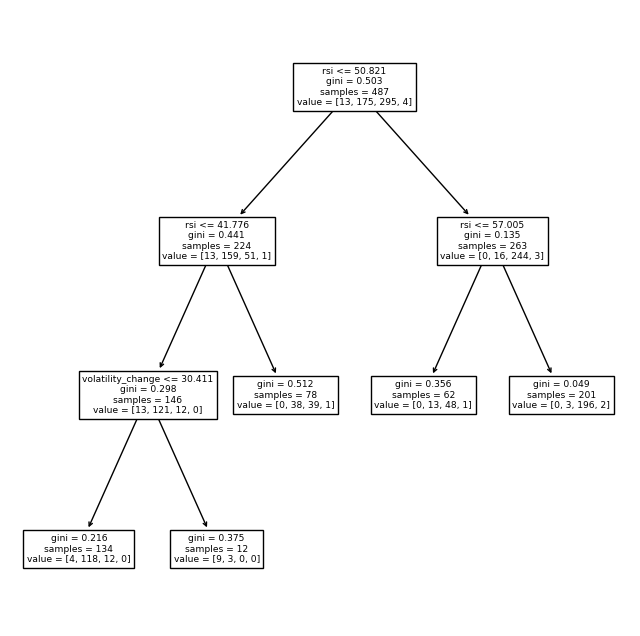

In [23]:
from sklearn.tree import _tree
from sklearn import tree

def tree_to_code(tree):
    tree_ = tree.tree_
    threshold_list = []

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            threshold = tree_.threshold[node]

            threshold_list.append(threshold)
            recurse(tree_.children_left[node], depth + 1)

            threshold_list.append(threshold)
            recurse(tree_.children_right[node], depth + 1)

    recurse(0, 1)
    thrl = np.unique(threshold_list)
    return thrl

#features_used = ["rsi"]
features_used = ["rsi","volatility_change"] #, "5d_vol"]
X = data[features_used]
y = data["Quantiles"]

clf_param = DecisionTreeClassifier(criterion= "gini", max_leaf_nodes=5, min_samples_split=20)
clf = clf_param.fit(X,y)

fig = plt.figure(figsize = (8,8))
tree.plot_tree(clf, feature_names= features_used )
plt.show()


In [24]:
from sklearn.metrics import accuracy_score
X_test = test_data[features_used]
y_test = test_data["Quantiles"]

# Make predictions on the test set
y_pred = clf.predict(X_test)
test_data['y_pred'] = y_pred
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 60.87%


In [25]:
print(test_data[["returns","5d_vol", "rsi", 'Quantiles', 'y_pred']])

             returns     5d_vol        rsi Quantiles  y_pred
Date                                                        
2020-06-02  1.544563  14.761231  72.784156         2       1
2020-06-03  0.822834  14.066862  93.924329         2       1
2020-06-04 -0.323038  12.673805  94.006385         2       1
2020-06-05  1.120922  11.228843  90.558347         2       1
2020-06-08  0.249141  10.455982  91.050478         2       1
2020-06-09 -1.195218   9.216644  96.549269         2       1
2020-06-10  0.689391   8.854591  88.930549         1       1
2020-06-11 -2.139644   7.974503  86.549546         1       1
2020-06-12  0.713470   9.316226  68.369758         1       1
2020-06-15 -1.609207   8.422927  67.720777         1       1
2020-06-16  1.016851   8.792708  49.390891         0       1
2020-06-17 -0.331896   8.252788  46.687674         0       1
2020-06-18  2.107945   7.402813  40.364950         1       0
2020-06-19  1.502287   8.516200  52.782234         1       1
2020-06-22  0.649945   8

In [26]:
data

,Adj Close,returns,rsi,omega,alpha[1],beta[1],h.1,h.2,h.3,h.4,h.5,5d_vol,volatility_change,rolling_returns,Quantiles
Date,,,,,,,,,,,,,,,
2018-06-01,10696.200195,-0.372803,53.536989,0.010793,0.044948,0.941254,0.508158,0.511940,0.515669,0.519347,0.522974,2.625079,2.456007,0.937420,1
2018-06-04,10628.500000,-0.634948,57.083361,0.010705,0.044417,0.941744,0.509792,0.513442,0.517042,0.520591,0.524092,2.578089,2.625079,1.057458,1
2018-06-05,10593.150391,-0.333147,58.138030,0.010530,0.043845,0.942368,0.496117,0.499806,0.503445,0.507034,0.510573,2.584959,2.578089,0.534318,1
2018-06-06,10684.650391,0.860057,54.023378,0.010561,0.043474,0.942548,0.505473,0.508968,0.512415,0.515813,0.519164,2.516975,2.584959,2.408838,1
2018-06-07,10768.349609,0.780307,68.570195,0.011064,0.045325,0.940368,0.512550,0.516281,0.519958,0.523583,0.527157,2.561832,2.516975,2.391784,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-26,9029.049805,-0.112907,40.834286,0.032690,0.089812,0.871240,2.518509,2.453110,2.390258,2.329853,2.271801,13.730769,15.318726,-2.300819,0
2020-05-27,9314.950195,3.117352,40.899314,0.030096,0.088120,0.876585,3.185527,3.103189,3.023757,2.947129,2.873205,11.963531,13.730769,1.279226,1
2020-05-28,9490.099609,1.862845,54.181690,0.029698,0.088054,0.877107,3.125625,3.046430,2.969994,2.896222,2.825019,15.132807,11.963531,1.129097,1


In [27]:
import pandas as pd
from scipy.stats import norm

# Create a sample DataFrame
data = {'A': [-10, 20, 30, 40, 50, 60, 70, 80, 800]}
df = pd.DataFrame(data)

# Calculate the rank of each element in the DataFrame
ranked_df = df.rank(axis=0)

# Apply the inverse normal transformation using scipy.stats.norm.ppf
inv_norm_df = norm.ppf(ranked_df / (len(df) + 1))

# Display the original DataFrame, ranked DataFrame, and transformed DataFrame
print("Original DataFrame:")
#print(df)

print("\nRanked DataFrame:")
#print(ranked_df)

print("\nInverse Normal Transformed DataFrame:")
print(inv_norm_df)

Original DataFrame:

Ranked DataFrame:

Inverse Normal Transformed DataFrame:
[[-1.28155157]
 [-0.84162123]
 [-0.52440051]
 [-0.2533471 ]
 [ 0.        ]
 [ 0.2533471 ]
 [ 0.52440051]
 [ 0.84162123]
 [ 1.28155157]]
